In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import linregress

In [14]:
#Границы отрезка и начальное условие в точке a
a = 1
b = 3
y0 = 1

In [15]:
def ODE(x, y):
    #Диф. уравнение
    return - (1 + x* y) / x ** 2

In [16]:
def exact_solution(x):
    #Точное решение диф. уравнения
    return (1 - np.log(np.abs(x))) / x

In [17]:
def runge_kutta_one_step(f, x, y, h, k1=None):
    ''' Шаг метода Рунге-Кутта 4-го порядка
        Функция принимает:
        f - диф. уравнение
        x - точку, в которой считаем новое приближение
        y - прошлое приближение
        h - длина шага 
        k1 - первый коэффициент (по умолчанию None)
        Функция возвращает новое приближение'''
    if k1 is None:
        k1 = f(x, y)
        
    k2 = f(x + h / 2, y + h / 2 * k1)
    k3 = f(x + h / 2, y + h / 2 * k2)
    k4 = f(x + h, y + h * k3)
    return y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [18]:
def runge_kutta(f, a, b, y0, h0, step='adaptive', eps=None, step_safe=False):
    ''' Метод Рунге-Кутта 4-го порядка
        Функция принимает:
        f - диф. уравнение
        a - левая граница отрезка
        b - правая граница отрезка
        y0 - начальное условие в точке a
        h0 - стартовый шаг
        eps - заданная точность 
        step - параметр
            adaptive - адаптивное изменение шага
            fixed - фиксированное значение шага
        step_safe - параметр
            True - сохраняем шаг
            False - не сохраняем шаг
        Функция возвращает численное решение на заданном отрезке'''
        
    x = a
    y = y0
    h = h0
    y_h1 = None
    y_2h = None
    # Список для хранения длин шага
    if step_safe == True:
        h_list = [h]

    # Список кортежей для хранения решения
    solution = [(x, y)]

    while x < b:
        # Условие для того, чтобы избежать выхода за пределы отрезка
        if x + 2 * h > b:
            h = (b - x) / 2
            
        # Делаем два шага метода по h
        if y_h1 is None:
            k1h = f(x, y)
            y_h1 = runge_kutta_one_step(f, x, y, h, k1=k1h)
            y_h2 = runge_kutta_one_step(f, x + h, y_h1, h)
        # Делаем один шаг 2h
        if y_2h is None:
            y_2h = runge_kutta_one_step(f, x, y, 2 * h, k1=k1h)

        # Вычисляем ошибку
        error = np.linalg.norm((y_2h - y_h2) / 15)
        
        # Применяем поправку Ричардсона
        y_new = y_h2 + (y_h2 - y_2h) / 15

        if step == 'adaptive':
            # Провеяем достижение заданной точности
            if error <= eps:  
                y_h1 = None
                y_2h = None
                x += 2 * h
                y = y_new
                solution.append((x, y))
                # Если ошибка намного меньше заданной точности, то увеличиваем шаг
                if error < eps / 32:
                    h *= 2
            # Если точность не достигнута, уменьшем шаг
            else: 
                h /= 2
                y_2h = y_h2 
                y_h1 = None
        
            if step_safe == True:
                h_list.append(h)

        elif step == 'fixed':
            y_h1 = None
            y_2h = None
            x += 2 * h
            y = y_new
            solution.append((x, y))
       
    if step_safe == True:
        x_list, _ = zip(*solution)
        return np.array(x_list), np.array(h_list)
    else:
        return solution

In [19]:
#Пострение графиков точного и численных решений для двух фиксированных значений шага на отрезке
h1 = 0.3
h2 = 0.1

x_list = np.linspace(a, b, 1000)

sol1 = runge_kutta(ODE, a, b, y0, h1, step='fixed')
x_h1, y_h1 = zip(*sol1)
sol2 = runge_kutta(ODE, a, b, y0, h2, step='fixed')
x_h2, y_h2 = zip(*sol2)

error_h1 = abs(y_h1 - exact_solution(x_h1))
error_h2 = abs(y_h2 - exact_solution(x_h2))

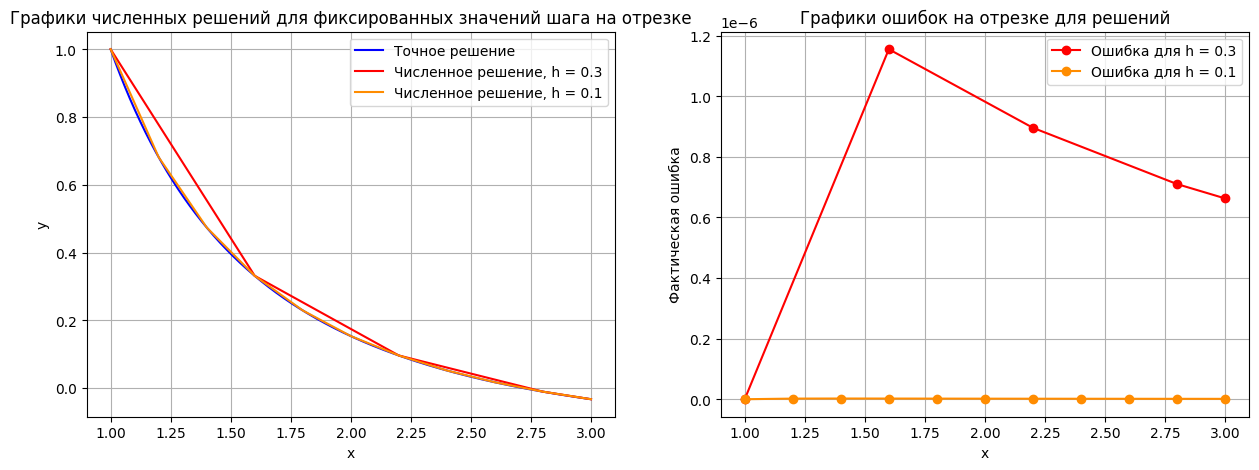

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(x_list, exact_solution(x_list), color='blue', label='Точное решение')
ax[0].plot(x_h1, y_h1, color = 'red', label=f'Численное решение, h = {h1}')
ax[0].plot(x_h2, y_h2, color = 'darkorange', label=f'Численное решение, h = {h2}')
ax[0].set_title('Графики численных решений для фиксированных значений шага на отрезке')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(x_h1, error_h1, color='red', label=f'Ошибка для h = {h1}', marker='o')
ax[1].plot(x_h2, error_h2, color='darkorange', label=f'Ошибка для h = {h2}', marker='o')
ax[1].set_title('Графики ошибок на отрезке для решений')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Фактическая ошибка')
for i in range(2):
    ax[i].grid(True)
    ax[i].legend()
    

In [21]:
#Строим зависимость фактической ошибки от заданной точности
eps_list = [0.1 ** k for k in range(1, 12) ]
solutions = [runge_kutta(ODE, a, b, y0, 1e-3, eps=i) for i in eps_list]
many_x = []
many_y = []
for i in range(len(eps_list)):
    sol_x, sol_y = zip(*solutions[i])
    many_x.append(sol_x)
    many_y.append(sol_y)
errors_from_eps = [np.linalg.norm(np.abs(many_y[i] - exact_solution(many_x[i]))) for i in range(len(eps_list))]

In [22]:
x_list, h_list = runge_kutta(ODE, a, b, y0, 1e-3, eps=1e-2, step_safe=True)

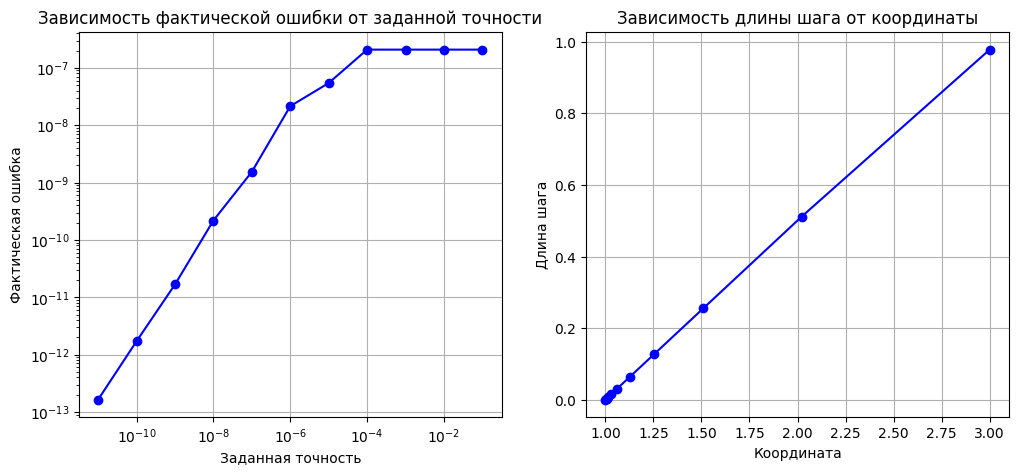

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].loglog(eps_list, errors_from_eps, color='blue', marker="o")
ax[0].set_title('Зависимость фактической ошибки от заданной точности')
ax[0].set_ylabel('Фактическая ошибка')
ax[0].set_xlabel('Заданная точность')

ax[1].plot(x_list, h_list, color='blue', marker='o')
ax[1].set_title('Зависимость длины шага от координаты')
ax[1].set_ylabel('Длина шага')
ax[1].set_xlabel('Координата')

for i in range(2):
    ax[i].grid(True)

In [24]:
# Строим зависимость фактической ошибки от фиксированной длины шага
h_list = [i for i in np.linspace(0.05, 0.95, 10)]
errors_from_fix_h = []
for i in h_list:
    x, y = zip(*runge_kutta(ODE, a, b, y0, i, step='fixed'))
    error = np.linalg.norm(np.abs(y - exact_solution(x))) 
    errors_from_fix_h.append(error)

Text(0, 0.5, 'Фактическая ошибка')

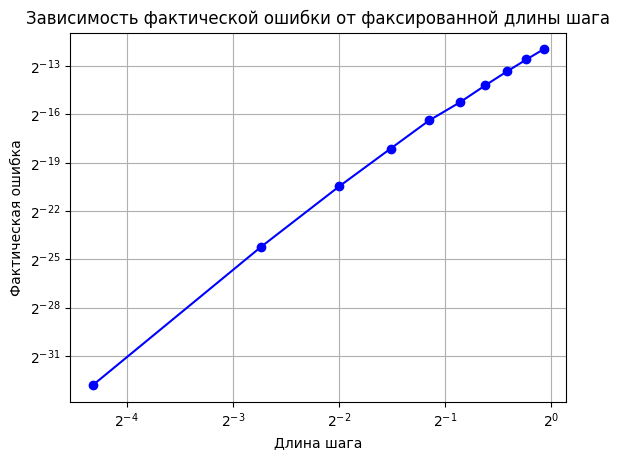

In [25]:
plt.loglog(h_list, errors_from_fix_h, base=2, color='blue', marker='o')
plt.grid(True)
plt.title('Зависимость фактической ошибки от факсированной длины шага')
plt.xlabel('Длина шага')
plt.ylabel('Фактическая ошибка')

In [26]:
# Определяем порядок метода
log_h = np.log2(h_list)
log_error = np.log2(errors_from_fix_h)
slope, _, _, _, _ = linregress(log_h, log_error)
slope

np.float64(4.885789863455909)

Дополнительное задание

In [27]:
import random

In [28]:
n = 5
many_lam = [-2, -4, -1, -10, -2]
y0_system = np.array([random.random() for _ in range(n)])

In [29]:
def create_matrix_with_eignvalues(eigenvalues, n):
    random_matrix = np.random.rand(n, n)
    Q, _ = np.linalg.qr(random_matrix)
    D = np.diag(eigenvalues)
    A = Q.T @ D @ Q
    return A

In [30]:
A = create_matrix_with_eignvalues(many_lam, n)
def ode_system(x, y):
    return A @ y

In [31]:
x_h1, y_h1 = zip(*runge_kutta(ode_system, 0, 4, y0_system, h1, step='fixed'))
x_h2, y_h2 = zip(*runge_kutta(ode_system, 0, 4, y0_system, h2, step='fixed'))
y_h1 = np.array(y_h1)
y_h2 = np.array(y_h2)

In [32]:
sol = solve_ivp(ode_system, (0, 4), y0_system, method='RK45', dense_output=True)
x = np.linspace(0, 4, 1000)
y = sol.sol(x)

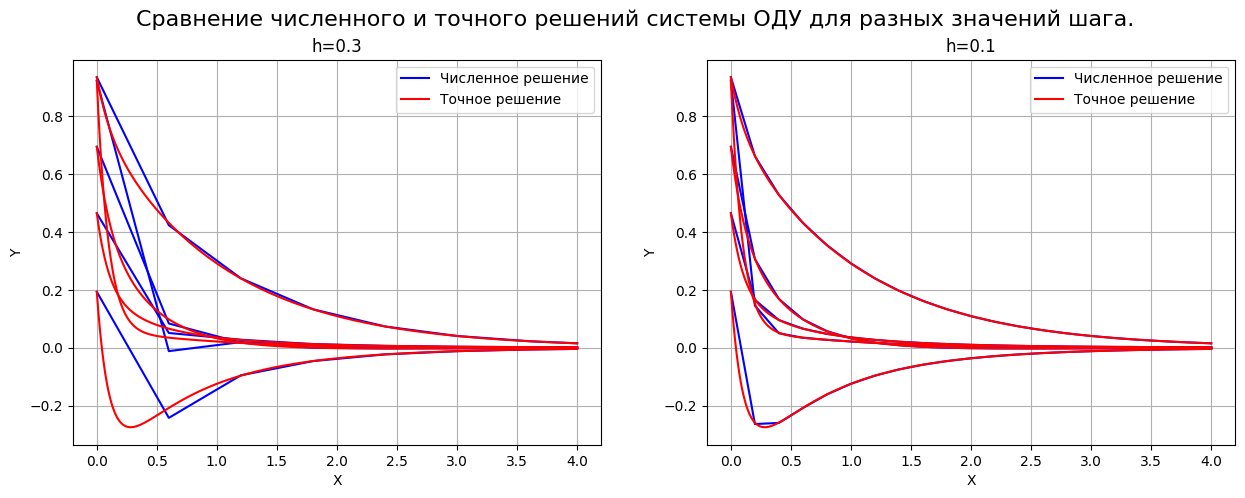

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Сравнение численного и точного решений системы ОДУ для разных значений шага.', fontsize=16)

ax[0].plot(x_h1, y_h1, color='blue')
ax[0].plot(x_h1[0], y_h1[0][0], label=f'Численное решение', color='blue')
ax[0].plot(x, y.T, color='red')
ax[0].plot(x[0], y.T[0][0], label=f'Точное решение', color='red')
ax[0].set_title('h=0.3')

ax[1].plot(x_h2, y_h2, color='blue')
ax[1].plot(x_h2[0], y_h2[0][0], label=f'Численное решение', color='blue')
ax[1].plot(x, y.T, color='red')
ax[1].plot(x[0], y.T[0][0], label=f'Точное решение', color='red')
ax[1].set_title('h=0.1')
for i in range(2):
    ax[i].grid('True')
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('Y')
    ax[i].legend()